<a href="https://colab.research.google.com/github/willcoomans5/mlb_predictions/blob/main/mlb_game_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [296]:
# import os, sys
# nb_path = '/content/notebooks'
# os.symlink('/content/drive/MyDrive/Colab Notebooks', nb_path)
# sys.path.insert(0,nb_path)

In [3]:
!pip3 install torch torchvision "ray[tune]" torchaudio pybaseball scikit-learn

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [6]:
import os
import sys
import json

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import *
import numpy as np
import pybaseball as pyb

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle

from datetime import date
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split



pyb.cache.enable()
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)


In [7]:
path = '/content/drive/MyDrive/mlbpredictions/'

In [ ]:
statcast_data = pyb.statcast(start_dt='2023-03-28', end_dt='2023-11-01')

This is a large query, it may take a moment to complete


100%|██████████| 219/219 [05:54<00:00,  1.62s/it]


In [ ]:
print(statcast_data.shape)
statcast_data.to_csv(path + "statcast_2023.csv")

In [8]:
sc = pd.read_csv(path + "statcast_2023.csv")
# data = sc.sample(200000, random_state=42)
data = sc

In [13]:
features = ['release_spin_rate', 'release_speed', 'release_extension',
            'release_pos_x', 'release_pos_z', 'spin_axis', 'vx0', 'vy0',
            'vz0', 'pfx_x', 'pfx_z', 'p_throws', 'balls', 'strikes']

target = 'pitch_name'
data = data[features + [target]]
X = data.drop(columns=["pitch_name"])
y = data["pitch_name"]

train_valid, test = train_test_split(data, test_size=0.2, random_state=42)
train, valid = train_test_split(train_valid, test_size=0.2, random_state=42)
print(train.shape)
print(valid.shape)
print(test.shape)

(468597, 15)
(117150, 15)
(146437, 15)


In [14]:
print(train["pitch_name"].value_counts())
print("\n")
print(train.isnull().sum())

pitch_name
4-Seam Fastball    151552
Slider              78932
Sinker              71426
Changeup            50930
Cutter              36517
Curveball           32048
Sweeper             23676
Split-Finger        10499
Knuckle Curve        9263
Slurve               1610
Other                 690
Forkball              504
Eephus                354
Knuckleball           130
Screwball              47
Slow Curve             31
Pitch Out              30
Name: count, dtype: int64


release_spin_rate    2885
release_speed         357
release_extension    1028
release_pos_x         357
release_pos_z         357
spin_axis            2885
vx0                   357
vy0                   357
vz0                   357
pfx_x                 357
pfx_z                 357
p_throws                0
balls                   0
strikes                 0
pitch_name            358
dtype: int64


Only 103 out of our 128000 training samples have missing dependent values. As shown above, these data points appear to be insignificant, as most of the remaining features have missing values as well. Consequently, removing these 103 rows is justified.

Below, we will handle the rest of the missing values appropriately. We will also one hot encode our "p_throws" column.



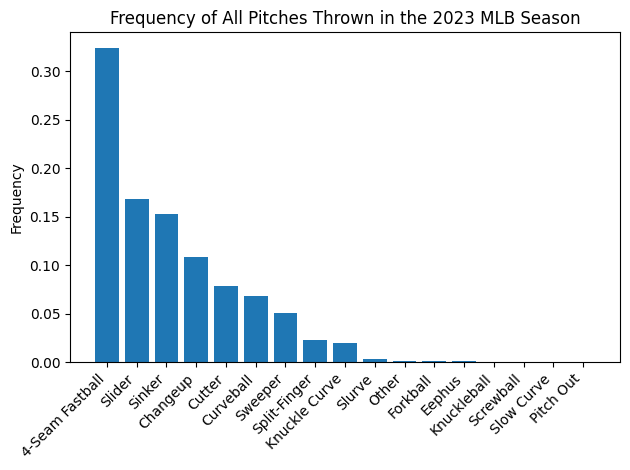

In [15]:
def remove_target_null(data):
  data = data[~data["pitch_name"].isnull()]
  return data

train = remove_target_null(train)

freq = train["pitch_name"].value_counts() / len(train)
plt.bar(x=freq.index, height=freq)
plt.xticks(rotation=45, ha='right')
plt.title("Frequency of All Pitches Thrown in the 2023 MLB Season")
plt.ylabel("Frequency")
plt.tight_layout()

In [16]:
# Map right handed pitchers to the value 1 and left handed pitchers to the value 0

def p_throws_ohe(data):
  mapping_dict = {"L": 0, "R": 1}

  # Check for existing numerical values and map only non-numerical values
  if type(data['p_throws'].iloc[0]) == str:
    data['p_throws'] = data['p_throws'].map(mapping_dict)
  return data


# Display the result
train = p_throws_ohe(train)
train.head()

,release_spin_rate,release_speed,release_extension,release_pos_x,release_pos_z,spin_axis,vx0,vy0,vz0,pfx_x,pfx_z,p_throws,balls,strikes,pitch_name
216099,1834.0,80.1,6.6,2.12,6.12,88.0,-8.177792,-115.872190,-8.426228,0.20,0.30,0,1,2,Slider
355273,2464.0,85.3,6.5,-1.98,6.47,72.0,5.459679,-124.035560,-8.254411,0.24,-0.06,1,1,2,Slider
444450,2582.0,84.4,6.2,-3.07,5.39,61.0,5.008387,-122.889500,-0.545208,0.85,-0.55,1,1,0,Slider
458053,1980.0,92.4,6.5,-1.30,5.55,226.0,8.337798,-134.220267,-5.483424,-1.55,0.62,1,0,0,Sinker
7451,2338.0,96.3,6.9,-2.02,6.33,220.0,5.144830,-140.020941,-6.430641,-0.72,1.12,1,3,2,4-Seam Fastball


Let's visualize some of the distributions of our features

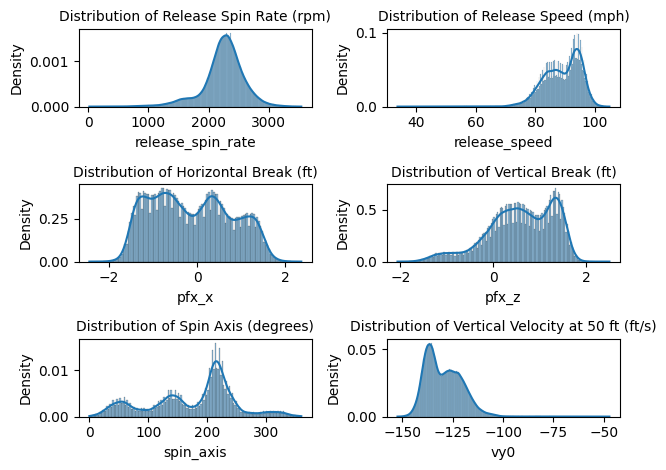

In [17]:
fig, ax = plt.subplots(3, 2)

sns.histplot(data=train, x="release_spin_rate", stat='density', kde=True, ax=ax[0, 0])
ax[0, 0].set_title("Distribution of Release Spin Rate (rpm)", fontsize=10)

sns.histplot(data=train, x="release_speed", stat='density', kde=True, ax=ax[0, 1])
ax[0, 1].set_title("Distribution of Release Speed (mph)", fontsize=10)

sns.histplot(data=train, x="pfx_x", stat='density', kde=True, ax=ax[1, 0])
ax[1, 0].set_title("Distribution of Horizontal Break (ft)", fontsize=10)

sns.histplot(data=train, x="pfx_z", stat='density', kde=True, ax=ax[1, 1])
ax[1, 1].set_title("Distribution of Vertical Break (ft)", fontsize=10)

sns.histplot(data=train, x="spin_axis", stat='density', kde=True, ax=ax[2, 0])
ax[2, 0].set_title("Distribution of Spin Axis (degrees)", fontsize=10)

sns.histplot(data=train, x="vy0", stat='density', kde=True, ax=ax[2, 1])
ax[2, 1].set_title("Distribution of Vertical Velocity at 50 ft (ft/s)", fontsize=10)


plt.tight_layout()
plt.show()

In [18]:
def fill_vals(data):
  data['release_spin_rate'] = data['release_spin_rate'].fillna(data['release_spin_rate'].mean())
  data['release_speed'] = data['release_speed'].fillna(data['release_speed'].mean())
  data['release_extension'] = data['release_extension'].fillna(data['release_extension'].mean())
  data['release_pos_x'] = data['release_pos_x'].fillna(data['release_pos_x'].mode()[0])
  data['release_pos_z'] = data['release_pos_z'].fillna(data['release_pos_z'].mean())
  data['spin_axis'] = data['spin_axis'].fillna(data['spin_axis'].mode()[0])
  data['pfx_x'] = data['pfx_x'].fillna(data['pfx_x'].mean())
  data['pfx_z'] = data['pfx_z'].fillna(data['pfx_z'].mean())
  data['vx0'] = data['vx0'].fillna(data['vx0'].mean())
  data['vy0'] = data['vy0'].fillna(data['vy0'].mean())
  data['vz0'] = data['vz0'].fillna(data['vz0'].mean())
  return data

train = fill_vals(train)
print(train.isnull().sum())

release_spin_rate    0
release_speed        0
release_extension    0
release_pos_x        0
release_pos_z        0
spin_axis            0
vx0                  0
vy0                  0
vz0                  0
pfx_x                0
pfx_z                0
p_throws             0
balls                0
strikes              0
pitch_name           0
dtype: int64


In [19]:
def label_encode(data):
  le = LabelEncoder()
  le.fit(data['pitch_name'])
  data['pitch_name'] = le.transform(data['pitch_name'])
  return data, le

train, le = label_encode(train)
for idx, label in enumerate(le.classes_):
  print(f"label: {label}, encoding: {idx}")

label: 4-Seam Fastball, encoding: 0
label: Changeup, encoding: 1
label: Curveball, encoding: 2
label: Cutter, encoding: 3
label: Eephus, encoding: 4
label: Forkball, encoding: 5
label: Knuckle Curve, encoding: 6
label: Knuckleball, encoding: 7
label: Other, encoding: 8
label: Pitch Out, encoding: 9
label: Screwball, encoding: 10
label: Sinker, encoding: 11
label: Slider, encoding: 12
label: Slow Curve, encoding: 13
label: Slurve, encoding: 14
label: Split-Finger, encoding: 15
label: Sweeper, encoding: 16


In [20]:
def normalize(data):
  cols = ['release_spin_rate', 'release_speed', 'release_extension',
            'release_pos_x', 'release_pos_z', 'spin_axis', 'vx0', 'vy0',
            'vz0', 'pfx_x', 'pfx_z', 'balls', 'strikes']

  df = data.copy()[cols]
  data.loc[:, cols] = (df - df.min()) / (df.max() - df.min())
  return data

train = normalize(train)
train

,release_spin_rate,release_speed,release_extension,release_pos_x,release_pos_z,spin_axis,vx0,vy0,vz0,pfx_x,pfx_z,p_throws,balls,strikes,pitch_name
216099,0.515306,0.652602,0.413793,0.727557,0.794074,0.244444,0.312963,0.346991,0.324834,0.550000,0.517544,0,0.25,1.0,12
355273,0.693878,0.725738,0.402299,0.299582,0.845926,0.200000,0.647717,0.269300,0.329641,0.558333,0.438596,1,0.25,1.0,12
444450,0.727324,0.713080,0.367816,0.185804,0.685926,0.169444,0.636639,0.280207,0.545317,0.685417,0.331140,1,0.25,0.0,12
458053,0.556689,0.825598,0.402299,0.370564,0.709630,0.627778,0.718365,0.172371,0.407163,0.185417,0.587719,1,0.00,0.0,11
7451,0.658163,0.880450,0.448276,0.295407,0.825185,0.611111,0.639988,0.117166,0.380663,0.358333,0.697368,1,0.75,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19607,0.659580,0.704641,0.310345,0.488518,0.850370,0.544444,0.525011,0.290187,0.385922,0.522917,0.508772,1,0.50,1.0,12
51153,0.599773,0.845288,0.425287,0.295407,0.703704,0.577778,0.617569,0.150875,0.477920,0.233333,0.671053,1,0.50,0.5,11
672799,0.578515,0.589311,0.482759,0.618998,0.749630,0.866667,0.472648,0.401840,0.596217,0.377083,0.276316,0,0.50,0.5,2
559700,0.633503,0.877637,0.425287,0.716075,0.780741,0.388889,0.249168,0.123455,0.348428,0.743750,0.638158,0,0.75,0.0,0


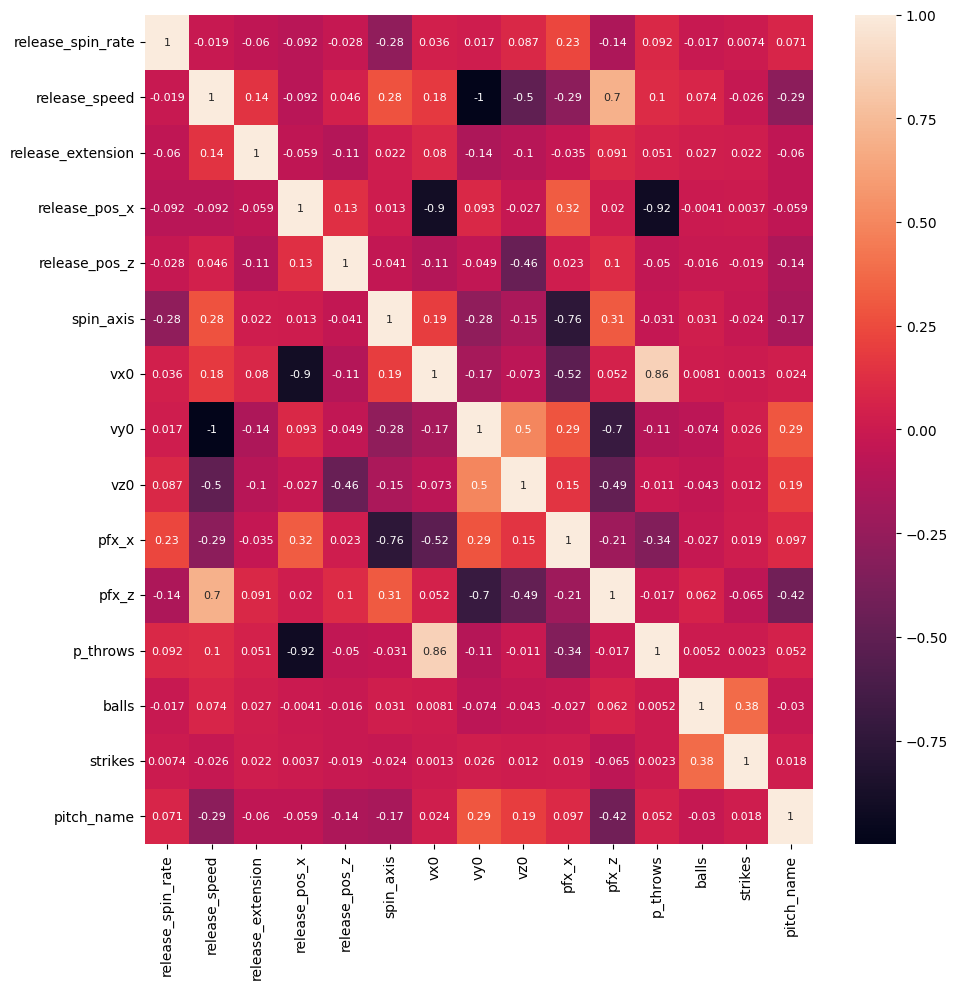

In [21]:


corr_data = train[features + [target]].corr(method='pearson')
plt.figure(figsize=(10, 10))
sns.heatmap(data=corr_data, annot=True, annot_kws={"size": 8})
plt.tight_layout()

In [22]:
def pipeline(data):
  df = data.copy()
  df = remove_target_null(df)
  df = p_throws_ohe(df)
  df = fill_vals(df)
  df = label_encode(df)[0]
  df = normalize(df)
  y = torch.tensor(df["pitch_name"].values, dtype=torch.long)
  X = torch.tensor(df.drop(columns=["pitch_name"]).values, dtype=torch.float32)
  return X, y

X_train, Y_train = pipeline(train)
X_valid, Y_valid = pipeline(valid)
X_test, Y_test = pipeline(test)


In [23]:
class CustomMLBDataSet(Dataset):
  def __init__(self, features, targets):
    self.features = features
    self.targets = targets

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    sample = self.features[idx], self.targets[idx]
    return sample

train_dataset = CustomMLBDataSet(X_train, Y_train)
valid_dataset = CustomMLBDataSet(X_valid, Y_valid)
test_dataset = CustomMLBDataSet(X_test, Y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [24]:
train_features, train_labels = next(iter(train_dataloader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')

Feature batch shape: torch.Size([32, 14])
Labels batch shape: torch.Size([32])


In [25]:
class NeuralNetwork(nn.Module):
  def __init__(self, input_size, h1, h2, output_size):
    super().__init__()
    self.feedforward = nn.Sequential(
        nn.Linear(input_size, h1, bias=True),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(h1, h2, bias=True),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(h2, output_size, bias=True),
    )

  def forward(self, x):
    logits = self.feedforward(x)
    return logits

  def pred_labels(self, logits):
    probs = nn.Softmax(dim=1)(logits)
    return torch.argmax(probs, dim=1)

In [248]:
def train_model(model, dataloader, epochs, lr, optimizer, save_path):
  '''
  Input: SoftmaxRegression model 'model', DataLoader 'dataloader', number of
  epochs 'epochs', learning rate 'lr', optimizer 'optimizer', and model saving
  path 'save_path'

  Output: returns a tuple of arrays (train_losses, valid_losses), each of length
  'epochs', where train_losses[i] is the average cross-entropy loss per training
  data point for the ith epoch, and valid_losses[i] is the average cross-entropy
  loss per validation data point for the ith epoch.
  '''

  loss_fn = nn.CrossEntropyLoss(reduction='sum')
  num_rows = len(dataloader.dataset)
  train_losses, valid_losses = [], []
  best_valid_loss = float('inf')

  for epoch in range(epochs):
    model.train()
    running_loss = 0
    for idx, data in enumerate(train_dataloader):
      features, labels = data

      # Each "features" has 64 samples, a tensor with dimensions (16, 14)
      # Each "labels" has 64 samples with, a tensor with dimensions(16, 1)
      features = features.to(device)
      labels = labels.to(device)

      # Feedforward the features to get our predictions from the neural network.
      logits = model(features)

      # Reset the gradients to zero since gradients accumulate with each call to backward()
      optimizer.zero_grad()

      # Compute the Cross Entropy Loss between our predictions and our true labels.
      # nn.CrossEntropyLoss() internally applies nn.LogSoftmax() and nn.NLLLoss()
      loss = loss_fn(logits, labels)

      # Compute the gradient of the loss function (cross-entropy) with respect to each parameter
      loss.backward()

      # Update the parameters with stochastic gradient descent
      optimizer.step()

      running_loss += loss.item()


    train_avg_loss = running_loss / num_rows
    train_losses.append(train_avg_loss)

    valid_avg_loss = assess_valid(model)
    valid_losses.append(valid_avg_loss)

    if valid_avg_loss < best_valid_loss:
      torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'valid_loss': valid_avg_loss
      }, save_path)
      best_valid_loss = valid_avg_loss



    print(f'EPOCH: {epoch}\n=============')
    print(f'Average Loss: {train_avg_loss}\n')

  with open(save_path + '_losses.json', 'w') as file:
    json.dump({"train_losses": train_losses, "valid_losses": valid_losses}, file)

  return train_losses, valid_losses


In [249]:
def assess_valid(model):
  '''
  Input: SoftmaxRegression model 'model'
  Output: returns average cross-entropy loss per data point in the validation set
  '''

  model.eval()
  loss_fn = nn.CrossEntropyLoss(reduction='sum')
  num_rows = len(valid_dataloader.dataset)
  total_loss = 0

  for features, labels in valid_dataloader:
    features = features.to(device)
    labels = labels.to(device)
    logits = model(features)
    loss = loss_fn(logits, labels)
    total_loss += loss.item()

  return total_loss / num_rows

In [9]:
# Tests the accuracy of a SoftmaxRegression model 'model' on the DataLoader 'dataloader'
# Returns an array 'losses' of length 'epochs', where losses[i] is the average cross-entropy loss per data point for the ith

def test_accuracy(model, dataloader):
  '''
  Input: SoftmaxRegression model 'model', DataLoader 'dataloader'
  Output: prints average cross-entropy loss per data point in the DataLoader
  'dataloader', accuracy on the dataloader's dataset
  '''

  model.eval()
  loss_fn = nn.CrossEntropyLoss(reduction='sum')
  total_loss = 0
  correct = 0
  num_rows = len(dataloader.dataset)

  with torch.no_grad():
    for i, data in enumerate(dataloader):
      features, labels = data
      features = features.to(device)
      labels = labels.to(device)

      logits = model.forward(features)
      preds = model.pred_labels(logits)

      total_loss += loss_fn(logits, labels)
      correct += torch.sum(preds == labels)

  accuracy = 100 * correct / num_rows
  avg_loss = total_loss / num_rows
  print(f'Average Loss: {avg_loss}')
  print(f'Accuracy: {accuracy}')



In [29]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'GPU device name: {torch.cuda.get_device_name(device)}')
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

adam_model = NeuralNetwork(14, 64, 32, 17).to(device)
print(adam_model)

No GPU available, using the CPU instead.
NeuralNetwork(
  (feedforward): Sequential(
    (0): Linear(in_features=14, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=17, bias=True)
  )
)


In [274]:
epochs = 10
lr = 0.001

optimizer = optim.Adam(adam_model.parameters(), lr=lr)

adam_train_losses, adam_valid_losses = train_model(adam_model, train_dataloader, epochs, lr, optimizer, path + 'models/model0.pt')

EPOCH: 0
Average Loss: 0.7171522129364077

EPOCH: 1
Average Loss: 0.5522450324887136

EPOCH: 2
Average Loss: 0.5273305498505964

EPOCH: 3
Average Loss: 0.5173806363060438

EPOCH: 4
Average Loss: 0.5099189314290546

EPOCH: 5
Average Loss: 0.5053388246912996

EPOCH: 6
Average Loss: 0.5007521244803793

EPOCH: 7
Average Loss: 0.496948939602031

EPOCH: 8
Average Loss: 0.4941450952041325

EPOCH: 9
Average Loss: 0.4926415969651217



In [280]:
sgd_model = NeuralNetwork(14, 64, 32, 17).to(device)
print(sgd_model)

NeuralNetwork(
  (feedforward): Sequential(
    (0): Linear(in_features=14, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=17, bias=True)
  )
)


In [281]:
epochs = 10
momentum = 0.9
lr = 0.001


optimizer = optim.SGD(sgd_model.parameters(), lr=lr, momentum=0.9)

sgd_train_losses, sgd_valid_losses = train_model(sgd_model, train_dataloader, epochs, lr, optimizer, path + 'models/model1.pt')

EPOCH: 0
Average Loss: 0.6956177347780595

EPOCH: 1
Average Loss: 0.5873329684034011

EPOCH: 2
Average Loss: 0.5699067761985778

EPOCH: 3
Average Loss: 0.5616594344191221

EPOCH: 4
Average Loss: 0.5550209334474461

EPOCH: 5
Average Loss: 0.5518225849976623

EPOCH: 6
Average Loss: 0.5498280957594162

EPOCH: 7
Average Loss: 0.5475887020477263

EPOCH: 8
Average Loss: 0.5459495468669442

EPOCH: 9
Average Loss: 0.5444292109275021



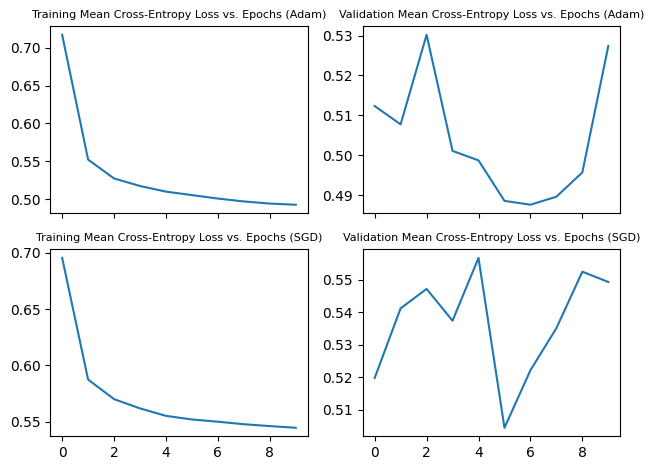

In [282]:
x = range(epochs)

fig, axs = plt.subplots(2, 2, sharex=True)

axs[0, 0].plot(x, adam_train_losses)
axs[0, 0].set_title('Training Mean Cross-Entropy Loss vs. Epochs (Adam)', fontsize=8)
axs[0, 1].plot(x, adam_valid_losses)
axs[0, 1].set_title('Validation Mean Cross-Entropy Loss vs. Epochs (Adam)', fontsize=8)

axs[1, 0].plot(x, sgd_train_losses)
axs[1, 0].set_title('Training Mean Cross-Entropy Loss vs. Epochs (SGD)', fontsize=8)
axs[1, 1].plot(x, sgd_valid_losses)
axs[1, 1].set_title('Validation Mean Cross-Entropy Loss vs. Epochs (SGD)', fontsize=8)

plt.tight_layout()

Here, we load the best model when we trained our NeuralNetwork with 25 epochs, Adam optimizer, and a learning rate of 0.001. We use all of the features from the list 'features', and have a single hidden layer with 16 nodes.

In [26]:
best_adam_model = NeuralNetwork(14, 64, 32, 17)
optimizer = optim.Adam(best_adam_model.parameters(), lr=0.001)

checkpoint = torch.load(path + 'models/model0.pt')
best_adam_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['valid_loss']

print(f'EPOCH: {epoch}\nValidation Loss: {loss}')

EPOCH: 6
Validation Loss: 0.4875868068824567


In [27]:
best_sgd_model = NeuralNetwork(14, 64, 32, 17)
optimizer = optim.SGD(best_sgd_model.parameters(), lr=0.001)

checkpoint = torch.load(path + 'models/model1.pt')
best_sgd_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['valid_loss']

print(f'EPOCH: {epoch}\nValidation Loss: {loss}')

EPOCH: 5
Validation Loss: 0.5045318577039155


In [34]:
print('Accuracy using Adam Optimizer:\n')
print('Training Set:')
test_accuracy(best_adam_model, train_dataloader)
print('\nValidation Set:')
test_accuracy(best_adam_model, valid_dataloader)
print('\nTest Set:')
test_accuracy(best_adam_model, test_dataloader)

Accuracy using Adam Optimizer:

Training Set:
Average Loss: 0.42887642979621887
Accuracy: 83.20857238769531

Validation Set:
Average Loss: 0.4875871241092682
Accuracy: 80.55679321289062

Test Set:
Average Loss: 0.4934964179992676
Accuracy: 80.72698211669922


In [33]:
print('Accuracy using SGD Optimizer:\n')
print('Training Set:')
test_accuracy(best_sgd_model, train_dataloader)
print('\nValidation Set:')
test_accuracy(best_sgd_model, valid_dataloader)
print('\nTest Set:')
test_accuracy(best_sgd_model, test_dataloader)

Accuracy using SGD Optimizer:

Training Set:
Average Loss: 0.4645904004573822
Accuracy: 81.75482940673828

Validation Set:
Average Loss: 0.50453120470047
Accuracy: 80.34323120117188

Test Set:
Average Loss: 0.525451123714447
Accuracy: 78.9300308227539
